In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold
)
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    OrdinalEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    precision_score,
    recall_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


df = pd.read_csv('./../community-policing-data.csv')
df.head()

/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_11880/1756410469.py:36: DtypeWarning: Columns (5,10,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./../community-policing-data.csv')


,STOP_DATE,AGENCY NAME,LOCATION,JURISDICTION,REASON FOR STOP,PERSON TYPE,RACE,ETHNICITY,AGE,GENDER,...,ACTION TAKEN,SPECIFIC VIOLATION,VIRGINIA CRIME CODE,PERSON SEARCHED,VEHICLE SEARCHED,ADDITIONAL ARREST,FORCE USED BY OFFICER,FORCE USED BY SUBJECT,RESIDENCY,VIOLATION TYPE
0,7/1/2020,Broadway Police Department,S MAIN/FORTH ST,ROCKINGHAM CO,TRAFFIC VIOLATION,NaN,WHITE,NOT HISPANIC OR LATINO,18.0,MALE,...,WARNING ISSUED,46.2-833,NaN,NO,NO,NO,NaN,NaN,NaN,COMMONWEALTH
1,7/1/2020,Isle Of Wight County Sheriff's Office,36.967676 -76.511763,ISLE OF WIGHT CO,TRAFFIC VIOLATION,NaN,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,26.0,MALE,...,WARNING ISSUED,46.2-804,NaN,NO,NO,NO,NaN,NaN,NaN,COMMONWEALTH
2,7/1/2020,Isle Of Wight County Sheriff's Office,36.95375 -76.540314,ISLE OF WIGHT CO,EQUIPMENT VIOLATION,NaN,UNKNOWN,UNKNOWN,82.0,NaN,...,WARNING ISSUED,46.2-1157,NaN,NO,NO,NO,NaN,NaN,NaN,COMMONWEALTH
3,7/1/2020,Isle Of Wight County Sheriff's Office,36.969732 -76.569873,ISLE OF WIGHT CO,EQUIPMENT VIOLATION,NaN,WHITE,UNKNOWN,61.0,MALE,...,WARNING ISSUED,46.2-1157,NaN,NO,NO,NO,NaN,NaN,NaN,COMMONWEALTH
4,7/1/2020,Isle Of Wight County Sheriff's Office,36.949132 -76.596691,ISLE OF WIGHT CO,TRAFFIC VIOLATION,NaN,WHITE,NOT HISPANIC OR LATINO,37.0,MALE,...,CITATION/SUMMONS,46.2-1157,NaN,NO,NO,NO,NaN,NaN,NaN,COMMONWEALTH


In [2]:
print(df.shape)

(3371015, 21)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3371015 entries, 0 to 3371014
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   STOP_DATE              object 
 1   AGENCY NAME            object 
 2   LOCATION               object 
 3   JURISDICTION           object 
 4   REASON FOR STOP        object 
 5   PERSON TYPE            object 
 6   RACE                   object 
 7   ETHNICITY              object 
 8   AGE                    float64
 9   GENDER                 object 
 10  ENGLISH SPEAKING       object 
 11  ACTION TAKEN           object 
 12  SPECIFIC VIOLATION     object 
 13  VIRGINIA CRIME CODE    object 
 14  PERSON SEARCHED        object 
 15  VEHICLE SEARCHED       object 
 16  ADDITIONAL ARREST      object 
 17  FORCE USED BY OFFICER  object 
 18  FORCE USED BY SUBJECT  object 
 19  RESIDENCY              object 
 20  VIOLATION TYPE         object 
dtypes: float64(1), object(20)
memory usage: 540.1+ MB


In [4]:
missing_values = df.isnull().sum()
print(missing_values)

STOP_DATE                      0
AGENCY NAME                    0
LOCATION                    4963
JURISDICTION                   8
REASON FOR STOP            22366
PERSON TYPE               958398
RACE                          15
ETHNICITY                     22
AGE                           56
GENDER                      2906
ENGLISH SPEAKING          966913
ACTION TAKEN                4214
SPECIFIC VIOLATION         73011
VIRGINIA CRIME CODE      2052157
PERSON SEARCHED            24128
VEHICLE SEARCHED           28504
ADDITIONAL ARREST        2442425
FORCE USED BY OFFICER     966413
FORCE USED BY SUBJECT     966431
RESIDENCY                1474357
VIOLATION TYPE           2427194
dtype: int64


In [5]:
# drop rows with crucial values missing
df = df.dropna(subset=['ACTION TAKEN', 'RACE', 'ETHNICITY', 'AGE', 'GENDER', 'REASON FOR STOP', 'LOCATION', 'SPECIFIC VIOLATION', 'JURISDICTION'])

In [6]:
missing_values = df.isnull().sum()
print(missing_values)

STOP_DATE                      0
AGENCY NAME                    0
LOCATION                       0
JURISDICTION                   0
REASON FOR STOP                0
PERSON TYPE               904247
RACE                           0
ETHNICITY                      0
AGE                            0
GENDER                         0
ENGLISH SPEAKING          907877
ACTION TAKEN                   0
SPECIFIC VIOLATION             0
VIRGINIA CRIME CODE      1951500
PERSON SEARCHED             2094
VEHICLE SEARCHED            4547
ADDITIONAL ARREST        2374625
FORCE USED BY OFFICER     907398
FORCE USED BY SUBJECT     907415
RESIDENCY                1400280
VIOLATION TYPE           2364865
dtype: int64


In [7]:
impute_NO = ["ADDITIONAL ARREST", "PERSON SEARCHED", "VEHICLE SEARCHED", "FORCE USED BY OFFICER", "FORCE USED BY SUBJECT"]
impute_YES = ["ENGLISH SPEAKING"]
impute_MISSING = ["VIOLATION TYPE", "PERSON TYPE"]
imput_UNKOWN = ["RESIDENCY"]

for col in impute_NO:
    df[col].fillna('NO', inplace=True)

for col in impute_YES:
    df[col].fillna('YES', inplace=True)

for col in impute_MISSING:
    df[col].fillna('MISSING', inplace=True)

for col in imput_UNKOWN:
    df[col].fillna('UNKNOWN', inplace=True)

/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_11880/85468143.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('NO', inplace=True)
/var/folders/ft/qj0q26cn6w51t2sg64_qw70r0000gn/T/ipykernel_11880/85468143.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [8]:
df["REASON FOR STOP"].value_counts()

REASON FOR STOP
TRAFFIC VIOLATION                2833792
EQUIPMENT VIOLATION               267523
CALLS FOR SERVICE                  74355
OTHER INVESTIGATIVE DETENTION      55983
TERRY STOP                         21471
CHECK POINT                         8994
ACCIDENT                            2267
WARRANT SERVICE                     1399
Name: count, dtype: int64

In [9]:
df["PERSON TYPE"].value_counts()

PERSON TYPE
DRIVER              2288300
MISSING              904247
OTHER INDIVIDUAL      60262
PASSENGER             12975
Name: count, dtype: int64

In [10]:
# get rid of row with ENGLISH SPEAKING value as 44108.47767
df = df[df["ENGLISH SPEAKING"] != 44108.47767]
df["ENGLISH SPEAKING"].value_counts()

ENGLISH SPEAKING
YES    3195105
NO       70678
Name: count, dtype: int64

In [11]:
df["ADDITIONAL ARREST"].value_counts()

ADDITIONAL ARREST
NO     3250571
YES      15212
Name: count, dtype: int64

In [12]:
# remove row with force used by officer value as "Driver"
df = df[df["FORCE USED BY OFFICER"] != "Driver"]
df["FORCE USED BY OFFICER"].value_counts()

FORCE USED BY OFFICER
NO     3261197
YES       4586
Name: count, dtype: int64

In [13]:
df["FORCE USED BY SUBJECT"].value_counts()

FORCE USED BY SUBJECT
NO     3261882
YES       3901
Name: count, dtype: int64

In [14]:
df["RESIDENCY"].value_counts()

RESIDENCY
UNKNOWN                                 1461483
RESIDENT OF CITY/COUNTY OF STOP          792199
OTHER VIRGINIA JURISDICTION RESIDENT     603571
OUT OF STATE RESIDENT                    408530
Name: count, dtype: int64

In [15]:
# for rows with violation type value as "Commonwealth", rename it to "COMMONWEALTH", and for rows with value as "Local", rename it to "LOCAL"
df["VIOLATION TYPE"] = df["VIOLATION TYPE"].replace("Commonwealth", "COMMONWEALTH")
df["VIOLATION TYPE"] = df["VIOLATION TYPE"].replace("Local", "LOCAL")
df["VIOLATION TYPE"].value_counts()

VIOLATION TYPE
MISSING         2364865
COMMONWEALTH     711717
LOCAL            189201
Name: count, dtype: int64

In [16]:
# drop rows with "JURISDICTION" value as "UNKNOWN"
df = df[df["JURISDICTION"] != "UNKNOWN"]
df["JURISDICTION"].value_counts()

JURISDICTION
FAIRFAX CO           162236
29                    97651
VIRGINIA BEACH        93028
HENRICO CO            91534
PRINCE WILLIAM CO     80416
                      ...  
18                       68
035                      28
076                      27
002                      13
000                       3
Name: count, Length: 273, dtype: int64

In [17]:
df["PERSON SEARCHED"].value_counts()

PERSON SEARCHED
NO     3172742
YES      93032
Name: count, dtype: int64

In [18]:
df["VEHICLE SEARCHED"].value_counts()

VEHICLE SEARCHED
NO     3202660
YES      63114
Name: count, dtype: int64

In [19]:
df['STOP_DATE'] = pd.to_datetime(df['STOP_DATE']).dt.strftime('%Y-%m-%d')
df["STOP_DATE"].value_counts()

STOP_DATE
2023-05-26    6668
2023-05-27    5966
2023-09-01    5940
2022-09-02    5662
2022-11-23    5550
              ... 
2021-02-18     757
2022-01-16     710
2021-01-31     688
2020-12-25     497
2022-01-03     451
Name: count, Length: 1218, dtype: int64

In [20]:
df = df.drop('VIRGINIA CRIME CODE', axis=1)

In [21]:
missing_values = df.isnull().sum()
print(missing_values)
print(df.shape)

STOP_DATE                0
AGENCY NAME              0
LOCATION                 0
JURISDICTION             0
REASON FOR STOP          0
PERSON TYPE              0
RACE                     0
ETHNICITY                0
AGE                      0
GENDER                   0
ENGLISH SPEAKING         0
ACTION TAKEN             0
SPECIFIC VIOLATION       0
PERSON SEARCHED          0
VEHICLE SEARCHED         0
ADDITIONAL ARREST        0
FORCE USED BY OFFICER    0
FORCE USED BY SUBJECT    0
RESIDENCY                0
VIOLATION TYPE           0
dtype: int64
(3265774, 20)


In [22]:
df.head(10)

,STOP_DATE,AGENCY NAME,LOCATION,JURISDICTION,REASON FOR STOP,PERSON TYPE,RACE,ETHNICITY,AGE,GENDER,ENGLISH SPEAKING,ACTION TAKEN,SPECIFIC VIOLATION,PERSON SEARCHED,VEHICLE SEARCHED,ADDITIONAL ARREST,FORCE USED BY OFFICER,FORCE USED BY SUBJECT,RESIDENCY,VIOLATION TYPE
0,2020-07-01,Broadway Police Department,S MAIN/FORTH ST,ROCKINGHAM CO,TRAFFIC VIOLATION,MISSING,WHITE,NOT HISPANIC OR LATINO,18.0,MALE,YES,WARNING ISSUED,46.2-833,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
1,2020-07-01,Isle Of Wight County Sheriff's Office,36.967676 -76.511763,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,26.0,MALE,YES,WARNING ISSUED,46.2-804,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
3,2020-07-01,Isle Of Wight County Sheriff's Office,36.969732 -76.569873,ISLE OF WIGHT CO,EQUIPMENT VIOLATION,MISSING,WHITE,UNKNOWN,61.0,MALE,YES,WARNING ISSUED,46.2-1157,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
4,2020-07-01,Isle Of Wight County Sheriff's Office,36.949132 -76.596691,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,WHITE,NOT HISPANIC OR LATINO,37.0,MALE,YES,CITATION/SUMMONS,46.2-1157,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
5,2020-07-01,Isle Of Wight County Sheriff's Office,36.949132 -76.596691,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,WHITE,NOT HISPANIC OR LATINO,20.0,MALE,YES,CITATION/SUMMONS,46.2-1157,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
6,2020-07-01,Isle Of Wight County Sheriff's Office,36.982597 -76.631202,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,BLACK OR AFRICAN AMERICAN,UNKNOWN,23.0,MALE,YES,CITATION/SUMMONS,46.2-300,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
7,2020-07-01,Isle Of Wight County Sheriff's Office,36.982597 -76.631202,ISLE OF WIGHT CO,EQUIPMENT VIOLATION,MISSING,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,50.0,MALE,YES,CITATION/SUMMONS,46.2-1052,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
8,2020-07-01,Isle Of Wight County Sheriff's Office,36.926835 -76.619655,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,27.0,FEMALE,YES,CITATION/SUMMONS,46.2-1157,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
9,2020-07-01,Isle Of Wight County Sheriff's Office,36.932577 -76.525736,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,58.0,MALE,YES,CITATION/SUMMONS,46.2-1173,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH
10,2020-07-01,Isle Of Wight County Sheriff's Office,36.830172 -76.77658,ISLE OF WIGHT CO,TRAFFIC VIOLATION,MISSING,WHITE,NOT HISPANIC OR LATINO,37.0,FEMALE,YES,CITATION/SUMMONS,46.2-870,NO,NO,NO,NO,NO,UNKNOWN,COMMONWEALTH


In [23]:
# # only return "SPECIFIC VIOLATION" value counts with less than 50,000

# value_counts = df2_cleaned["SPECIFIC VIOLATION"].value_counts()

# # Filter for counts less than 50,000
# filtered_counts = value_counts[value_counts < 2000]

# # Display the result
# print(filtered_counts)


# # df2_cleaned["SPECIFIC VIOLATION"].value_counts()

LOCATION: 0.9194
PERSON SEARCHED: 0.6220
SPECIFIC VIOLATION: 0.5627
AGENCY NAME: 0.3357
REASON FOR STOP: 0.3079
PERSON TYPE: 0.2950
JURISDICTION: 0.2816
VEHICLE SEARCHED: 0.2642
STOP_DATE: 0.1301
AGE: 0.1188
FORCE USED BY OFFICER: 0.1054
FORCE USED BY SUBJECT: 0.0930
ADDITIONAL ARREST: 0.0822
RESIDENCY: 0.0672
ENGLISH SPEAKING: 0.0590
ETHNICITY: 0.0525
VIOLATION TYPE: 0.0476
RACE: 0.0469
GENDER: 0.0379


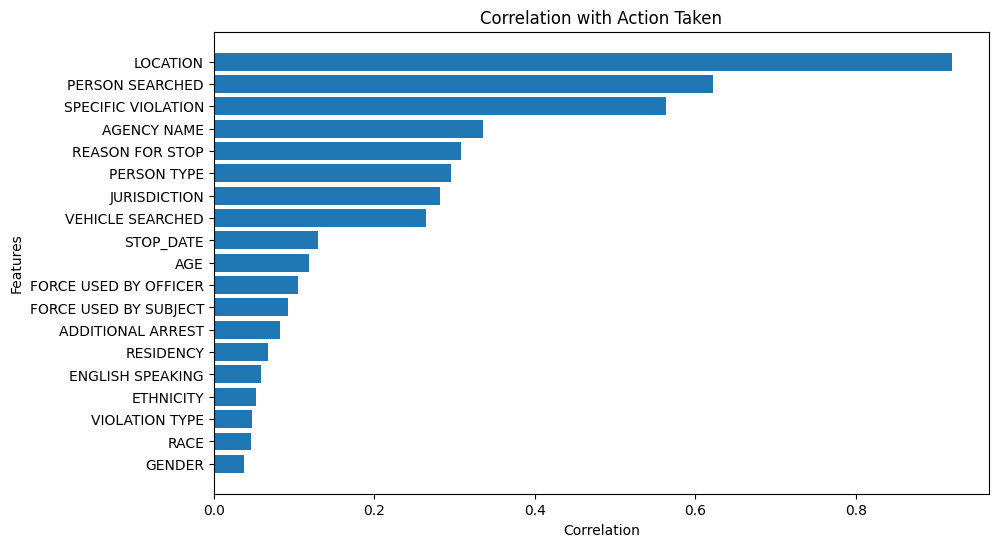

In [88]:
# Cramér's V function
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Get all feature columns
features = df.columns.tolist()

# List to store correlations
corr = []

# Iterate through features and calculate Cramér's V for each
for feature in features:
    if feature != "ACTION TAKEN":  # Avoid comparing the target variable with itself
        corr_value = cramers_v(df[feature], df["ACTION TAKEN"])  # Pass the actual data
        corr.append((feature, corr_value))  # Append as a tuple (feature name, correlation)

# Sort the results by correlation value (descending order)
corr.sort(key=lambda x: x[1], reverse=True)

# Print the sorted correlations
for feature, value in corr:
    print(f"{feature}: {value:.4f}")

# Unpack the tuples into two separate lists: importances and feature names
feature, value = zip(*corr)

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.barh(feature, value, align='center')  # Horizontal bar graph

# Add titles and labels
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.title("Correlation with Action Taken")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Show the plot
plt.show()

In [25]:
# downsample the entire dataset to 100,000 rows
df, _ = train_test_split(
    df,
    train_size=100000,  # Specify the total size
    stratify=df['ACTION TAKEN'],  # Stratify on the target variable
    random_state=42
)

X = df.drop(columns=['ACTION TAKEN'])
y = df['ACTION TAKEN'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

num_attrs = ["AGE"]
nominal_cat_attrs = set(df.columns.tolist())
nominal_cat_attrs.remove("AGE")
nominal_cat_attrs.remove("STOP_DATE")
nominal_cat_attrs.remove("ACTION TAKEN")
nominal_cat_attrs = list(nominal_cat_attrs)
ordinal_cat_attrs = ["STOP_DATE"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attrs),
    ('nom_cat', OneHotEncoder(handle_unknown="ignore"), nominal_cat_attrs),
    ('ord_cat', OrdinalEncoder(), ordinal_cat_attrs)
])

X_train_prepared = full_pipeline.fit_transform(X_train)
print(X_train.shape)
print(X_train_prepared.shape)
X_test_prepared = full_pipeline.transform(X_test)
print(X_test.shape)
print(X_test_prepared.shape)

(80000, 19)
(80000, 55262)
(20000, 19)
(20000, 55262)


### models

In [27]:
# Instantiate the logistic regression model
log_reg = LogisticRegression(
    multi_class='multinomial',  # Use multinomial for multiclass
    solver='lbfgs',  # Recommended solver for multiclass problems
    max_iter=1000,  # Increase iterations for convergence if needed
    random_state=42
)

# Train the model on the prepared training data
log_reg.fit(X_train_prepared, y_train)

# Evaluate on the test set
y_pred = log_reg.predict(X_test_prepared)

print("Classification Report:")
print(classification_report(y_test, y_pred))

/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                       precision    recall  f1-score   support

               ARREST       0.80      0.69      0.74       592
     CITATION/SUMMONS       0.76      0.88      0.81     12694
NO ENFORCEMENT ACTION       0.36      0.03      0.06       360
       WARNING ISSUED       0.65      0.47      0.55      6354

             accuracy                           0.73     20000
            macro avg       0.64      0.52      0.54     20000
         weighted avg       0.72      0.73      0.71     20000



In [28]:
# Instantiate the logistic regression model
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Perform cross-validation on the training data
cv_scores = cross_val_score(log_reg, X_train_prepared, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("Logistic Regression Cross-Validation Accuracy Scores:", cv_scores)
print("Logistic Regression Mean CV Accuracy:", cv_scores.mean())

# Train on the full training set and evaluate on the test set
log_reg.fit(X_train_prepared, y_train)
y_pred = log_reg.predict(X_test_prepared)

print("\nLogistic Regression Test Set Classification Report:")
print(classification_report(y_test, y_pred))

/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_mo

Logistic Regression Cross-Validation Accuracy Scores: [0.7313125 0.7294375 0.7296875 0.7311875 0.726875 ]
Logistic Regression Mean CV Accuracy: 0.7297


/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Test Set Classification Report:
                       precision    recall  f1-score   support

               ARREST       0.80      0.69      0.74       592
     CITATION/SUMMONS       0.76      0.88      0.81     12694
NO ENFORCEMENT ACTION       0.36      0.03      0.06       360
       WARNING ISSUED       0.65      0.47      0.55      6354

             accuracy                           0.73     20000
            macro avg       0.64      0.52      0.54     20000
         weighted avg       0.72      0.73      0.71     20000



In [29]:
# Instantiate the random forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Utilize all processors for faster training
)

# Perform cross-validation on the training data
cv_scores = cross_val_score(rf_clf, X_train_prepared, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("Random Forest Cross-Validation Accuracy Scores:", cv_scores)
print("Random Forest Mean CV Accuracy:", cv_scores.mean())

# Train on the full training set and evaluate on the test set
rf_clf.fit(X_train_prepared, y_train)
y_pred = rf_clf.predict(X_test_prepared)

print("\nRandom Forest Test Set Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Cross-Validation Accuracy Scores: [0.7421875 0.7398125 0.7440625 0.742125  0.7355625]
Random Forest Mean CV Accuracy: 0.74075

Random Forest Test Set Classification Report:
                       precision    recall  f1-score   support

               ARREST       0.85      0.74      0.79       592
     CITATION/SUMMONS       0.76      0.90      0.83     12694
NO ENFORCEMENT ACTION       0.55      0.12      0.20       360
       WARNING ISSUED       0.69      0.46      0.55      6354

             accuracy                           0.75     20000
            macro avg       0.71      0.56      0.59     20000
         weighted avg       0.73      0.75      0.73     20000



In [30]:
# Instantiate the gradient boosting model
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Perform cross-validation on the training data
cv_scores = cross_val_score(gb_clf, X_train_prepared, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("Gradient Boosting Cross-Validation Accuracy Scores:", cv_scores)
print("Gradient Boosting Mean CV Accuracy:", cv_scores.mean())

# Train on the full training set and evaluate on the test set
gb_clf.fit(X_train_prepared, y_train)
y_pred = gb_clf.predict(X_test_prepared)

print("\nGradient Boosting Test Set Classification Report:")
print(classification_report(y_test, y_pred))

Gradient Boosting Cross-Validation Accuracy Scores: [0.722375  0.7239375 0.7235    0.72525   0.718875 ]
Gradient Boosting Mean CV Accuracy: 0.7227875

Gradient Boosting Test Set Classification Report:
                       precision    recall  f1-score   support

               ARREST       0.86      0.71      0.78       592
     CITATION/SUMMONS       0.72      0.94      0.82     12694
NO ENFORCEMENT ACTION       0.47      0.19      0.27       360
       WARNING ISSUED       0.71      0.33      0.45      6354

             accuracy                           0.72     20000
            macro avg       0.69      0.54      0.58     20000
         weighted avg       0.72      0.72      0.69     20000



In [31]:
# Instantiate the SVM model
svm_clf = SVC(
    kernel='rbf',  # Radial basis function kernel
    probability=True,  # Enable probability estimates for compatibility with other metrics
    random_state=42
)

# Perform cross-validation on the training data
cv_scores = cross_val_score(svm_clf, X_train_prepared, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("SVM Cross-Validation Accuracy Scores:", cv_scores)
print("SVM Mean CV Accuracy:", cv_scores.mean())

# Train on the full training set and evaluate on the test set
svm_clf.fit(X_train_prepared, y_train)
y_pred = svm_clf.predict(X_test_prepared)

print("\nSVM Test Set Classification Report:")
print(classification_report(y_test, y_pred))

SVM Cross-Validation Accuracy Scores: [0.6331875 0.63325   0.63325   0.63325   0.63325  ]
SVM Mean CV Accuracy: 0.6332374999999999

SVM Test Set Classification Report:


/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

               ARREST       0.00      0.00      0.00       592
     CITATION/SUMMONS       0.63      1.00      0.78     12694
NO ENFORCEMENT ACTION       0.00      0.00      0.00       360
       WARNING ISSUED       0.00      0.00      0.00      6354

             accuracy                           0.63     20000
            macro avg       0.16      0.25      0.19     20000
         weighted avg       0.40      0.63      0.49     20000



/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### feature importance

55262 55262
LOCATION: 0.3401
SPECIFIC VIOLATION: 0.1609
JURISDICTION: 0.1194
AGENCY NAME: 0.1136
STOP_DATE: 0.0642
AGE: 0.0627
REASON FOR STOP: 0.0226
RESIDENCY: 0.0215
RACE: 0.0199
GENDER: 0.0196
PERSON SEARCHED: 0.0171
PERSON TYPE: 0.0114
ETHNICITY: 0.0108
VIOLATION TYPE: 0.0067
VEHICLE SEARCHED: 0.0047
ENGLISH SPEAKING: 0.0032
ADDITIONAL ARREST: 0.0010
FORCE USED BY OFFICER: 0.0005
FORCE USED BY SUBJECT: 0.0003


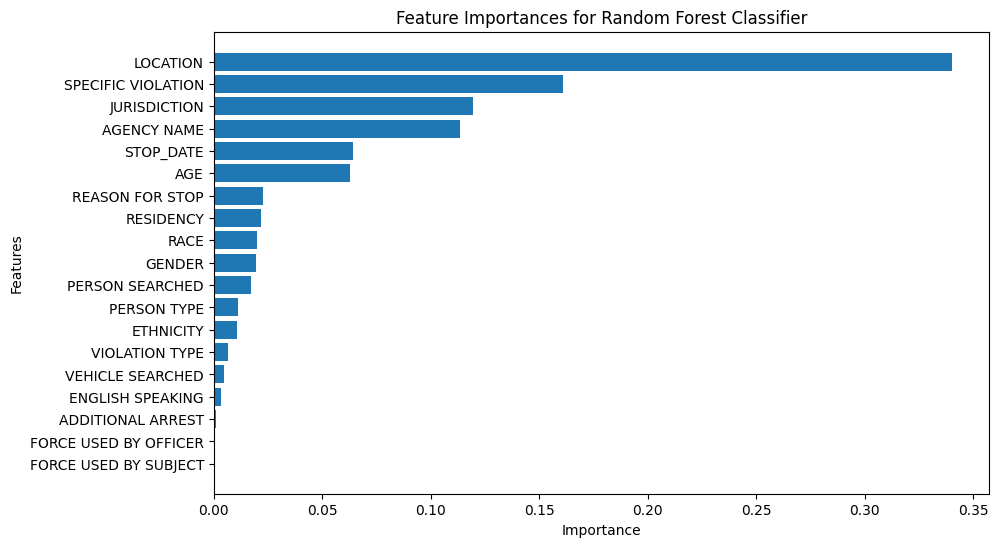

In [89]:
from collections import defaultdict
feature_importances = rf_clf.feature_importances_

nom_cat_encoder = full_pipeline.named_transformers_["nom_cat"]
nom_cat_one_hot_attribs = []
for i, categories in enumerate(nom_cat_encoder.categories_):
    nom_cat_one_hot_attribs += [f"{nominal_cat_attrs[i]}_{category}" for category in categories]

ord_cat_encoder = full_pipeline.named_transformers_["ord_cat"]
ord_cat_attribs = ordinal_cat_attrs

attrs = num_attrs + nom_cat_one_hot_attribs + ord_cat_attribs

# Double check lengths match, otherwise there is not a correct mapping
print(len(feature_importances), len(attrs))

aggregated_nominal_cat = defaultdict(float)

sorted_feature_importances = sorted(zip(feature_importances, attrs), reverse=True)
sorted_aggregates = []
for importance, name in sorted_feature_importances:
    if name.split("_")[0] in nominal_cat_attrs:
        aggregated_nominal_cat[name.split("_")[0]] += importance
    else:
        sorted_aggregates.append((importance, name))

for name in aggregated_nominal_cat:
    sorted_aggregates.append((aggregated_nominal_cat[name], name))

sorted_aggregates.sort(reverse=True)
for importance, name in sorted_aggregates:
    print(f"{name}: {importance:.4f}")

# make a bar graph of the feature importances

# Unpack the tuples into two separate lists: importances and feature names
importances, feature_names = zip(*sorted_aggregates)

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.barh(feature_names, importances, align='center')  # Horizontal bar graph

# Add titles and labels
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances for Random Forest Classifier")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Show the plot
plt.show()

55262 55262
SPECIFIC VIOLATION: 0.4585
AGENCY NAME: 0.2323
PERSON SEARCHED: 0.1226
REASON FOR STOP: 0.0713
AGE: 0.0331
PERSON TYPE: 0.0216
JURISDICTION: 0.0150
LOCATION: 0.0111
RESIDENCY: 0.0096
STOP_DATE: 0.0077
VIOLATION TYPE: 0.0070
ETHNICITY: 0.0054
RACE: 0.0024
VEHICLE SEARCHED: 0.0010
GENDER: 0.0006
ENGLISH SPEAKING: 0.0003
ADDITIONAL ARREST: 0.0003
FORCE USED BY SUBJECT: 0.0000
FORCE USED BY OFFICER: 0.0000


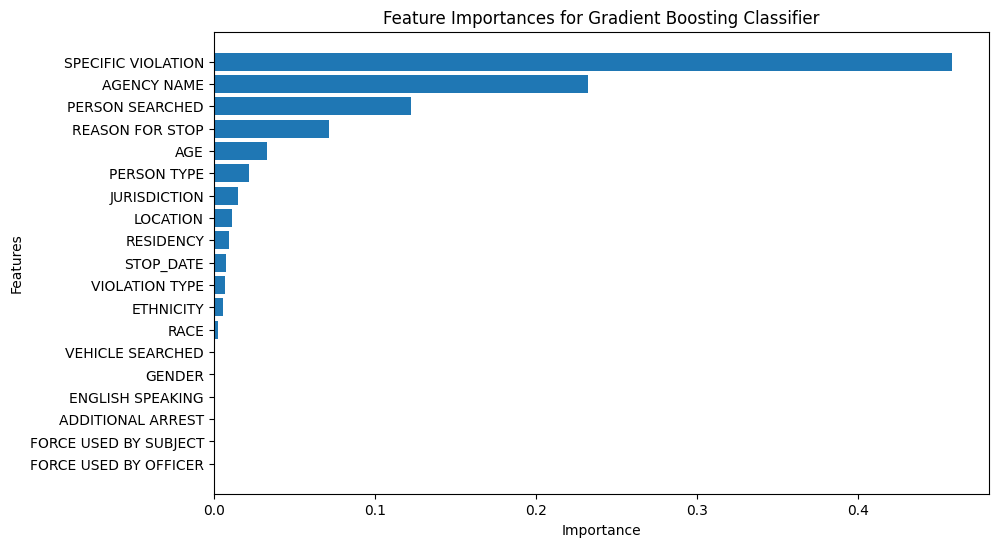

In [90]:
from collections import defaultdict
feature_importances = gb_clf.feature_importances_

nom_cat_encoder = full_pipeline.named_transformers_["nom_cat"]
nom_cat_one_hot_attribs = []
for i, categories in enumerate(nom_cat_encoder.categories_):
    nom_cat_one_hot_attribs += [f"{nominal_cat_attrs[i]}_{category}" for category in categories]

ord_cat_encoder = full_pipeline.named_transformers_["ord_cat"]
ord_cat_attribs = ordinal_cat_attrs

attrs = num_attrs + nom_cat_one_hot_attribs + ord_cat_attribs

# Double check lengths match, otherwise there is not a correct mapping
print(len(feature_importances), len(attrs))

aggregated_nominal_cat = defaultdict(float)

sorted_feature_importances = sorted(zip(feature_importances, attrs), reverse=True)
sorted_aggregates = []
for importance, name in sorted_feature_importances:
    if name.split("_")[0] in nominal_cat_attrs:
        aggregated_nominal_cat[name.split("_")[0]] += importance
    else:
        sorted_aggregates.append((importance, name))

for name in aggregated_nominal_cat:
    sorted_aggregates.append((aggregated_nominal_cat[name], name))

sorted_aggregates.sort(reverse=True)
for importance, name in sorted_aggregates:
    print(f"{name}: {importance:.4f}")

# Unpack the tuples into two separate lists: importances and feature names
importances, feature_names = zip(*sorted_aggregates)

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.barh(feature_names, importances, align='center')  # Horizontal bar graph

# Add titles and labels
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances for Gradient Boosting Classifier")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Show the plot
plt.show()

### visualizations

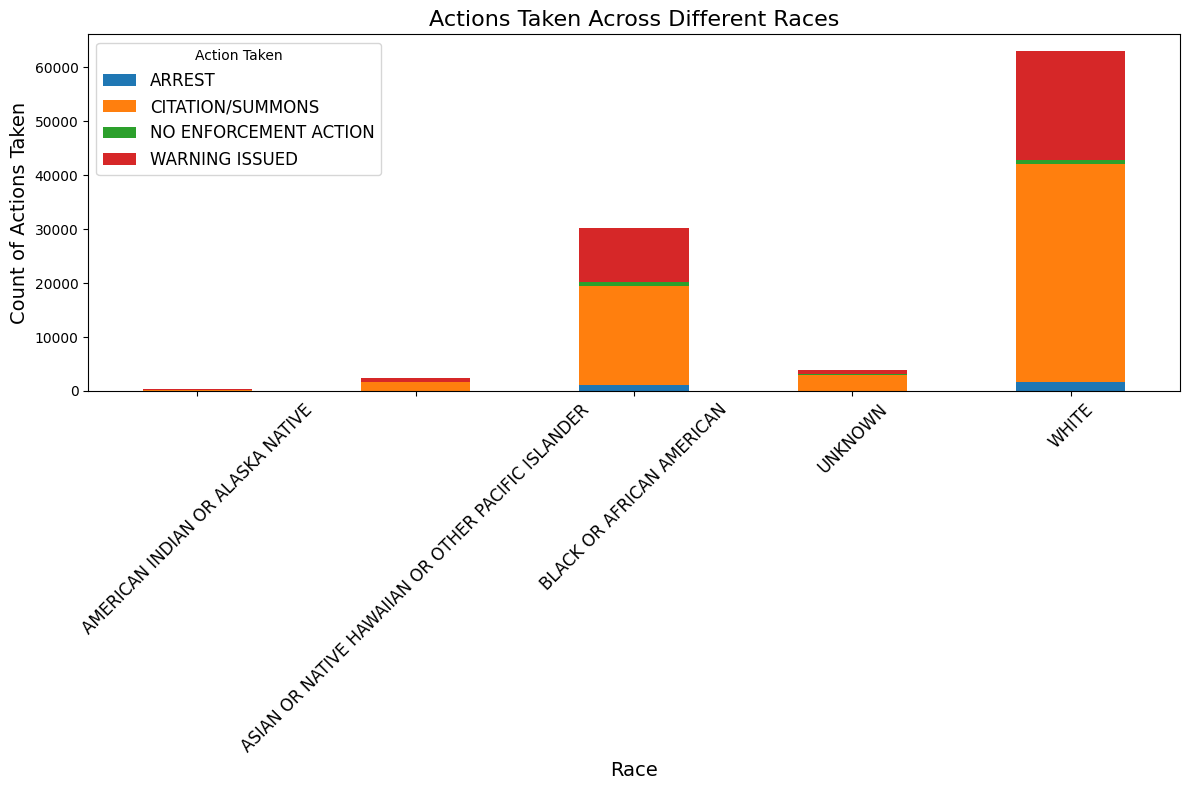

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame is already loaded as `df`
# Example structure:
# df = pd.read_csv('community-policing-data.csv')

# Group the data by race and action taken
grouped_data = df.groupby(['RACE', 'ACTION TAKEN']).size().unstack(fill_value=0)

# Plot a stacked bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))

# Adding titles and labels
plt.title('Actions Taken Across Different Races', fontsize=16)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Count of Actions Taken', fontsize=14)
plt.legend(title='Action Taken', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Group the data by race and action taken
grouped_data = df.groupby(['RACE', 'ACTION TAKEN']).size().unstack(fill_value=0)

# Calculate proportions by dividing each count by the total counts for each race
proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Display the proportions as percentages
proportions *= 100  # Convert to percentages

# Save or display the proportions
print(proportions)

ACTION TAKEN                                          ARREST  \
RACE                                                           
AMERICAN INDIAN OR ALASKA NATIVE                    0.000000   
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER  2.232143   
BLACK OR AFRICAN AMERICAN                           3.846408   
UNKNOWN                                             0.740174   
WHITE                                               2.594763   

ACTION TAKEN                                        CITATION/SUMMONS  \
RACE                                                                   
AMERICAN INDIAN OR ALASKA NATIVE                           63.305322   
ASIAN OR NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER         63.149351   
BLACK OR AFRICAN AMERICAN                                  60.261490   
UNKNOWN                                                    75.625319   
WHITE                                                      64.084608   

ACTION TAKEN                                  

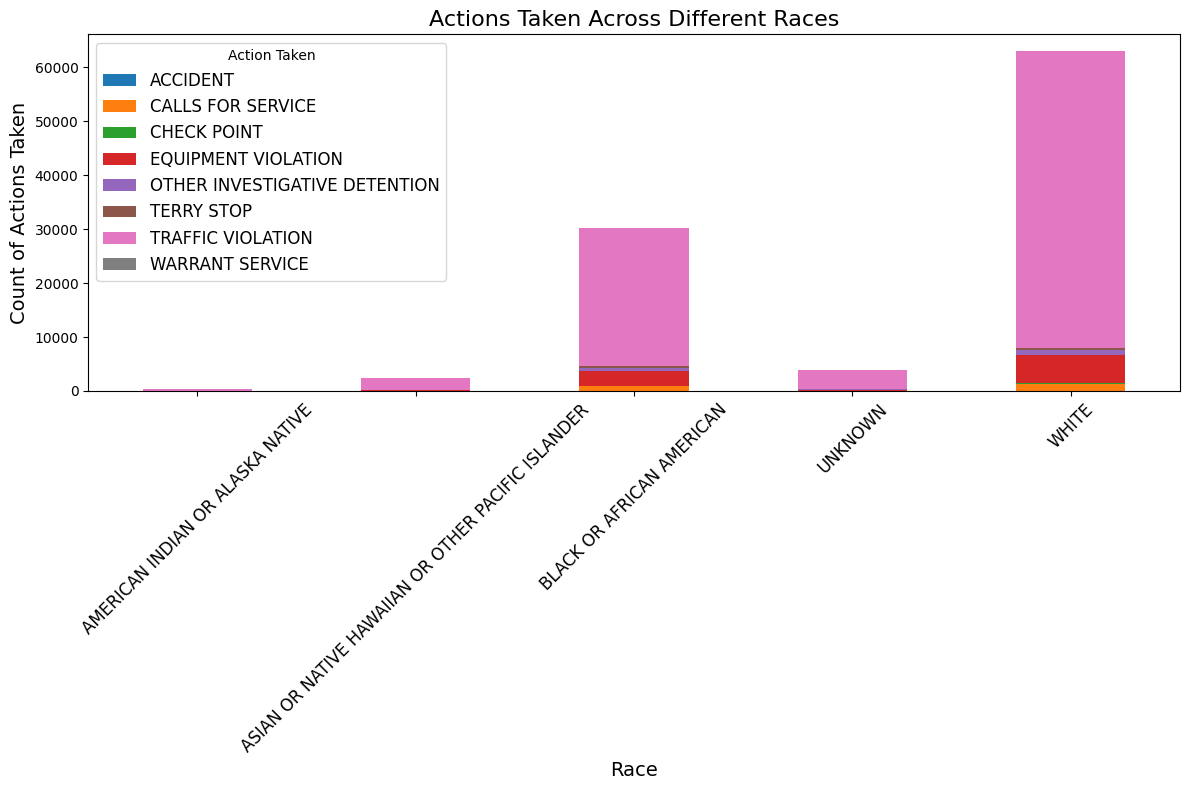

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame is already loaded as `df`
# Example structure:
# df = pd.read_csv('community-policing-data.csv')

# Group the data by race and action taken
grouped_data = df.groupby(['RACE', 'REASON FOR STOP']).size().unstack(fill_value=0)

# Plot a stacked bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))

# Adding titles and labels
plt.title('Actions Taken Across Different Races', fontsize=16)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Count of Actions Taken', fontsize=14)
plt.legend(title='Action Taken', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

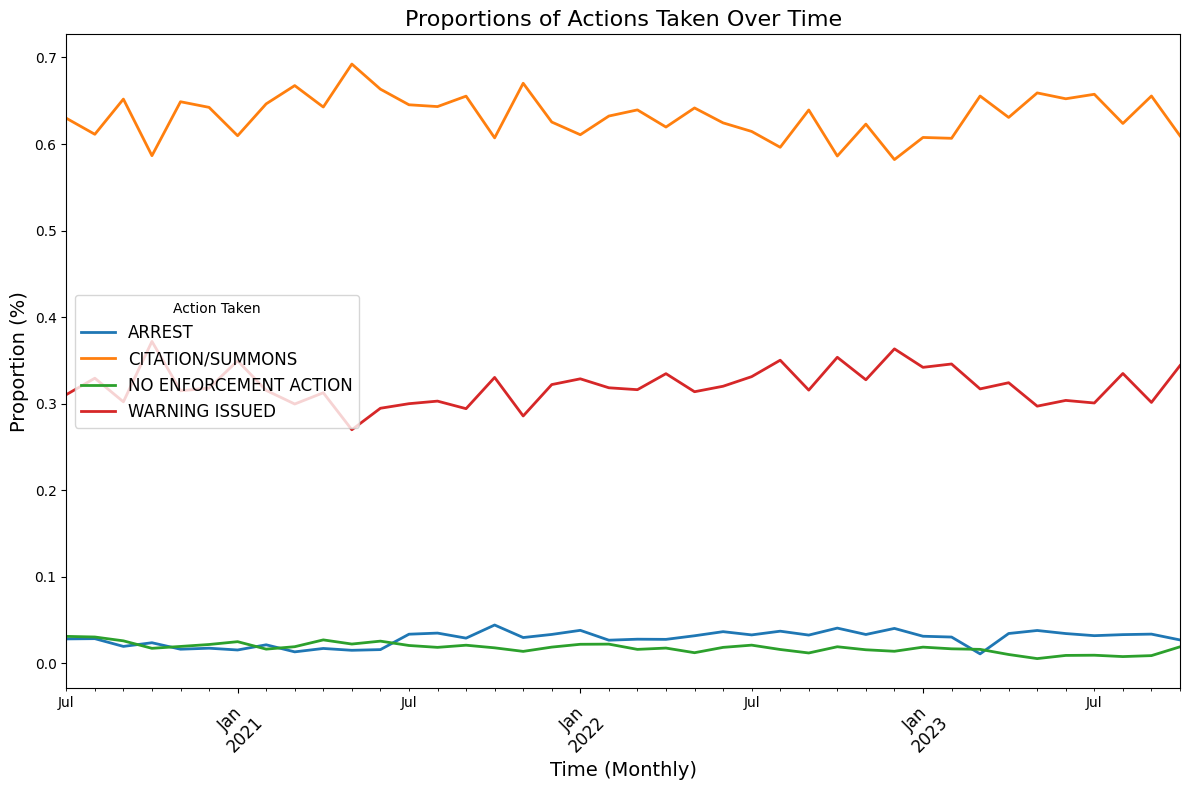

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame is already loaded as `df`
# Ensure the DATE column is in datetime format
df['STOP_DATE'] = pd.to_datetime(df['STOP_DATE'])  # Replace 'DATE' with the actual date column name

# Group by date and calculate proportions for 'ACTION TAKEN'
grouped_data = df.groupby([df['STOP_DATE'].dt.to_period('M'), 'ACTION TAKEN']).size().unstack(fill_value=0)

# Calculate proportions
proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Plotting the trends for each action taken
proportions.plot(figsize=(12, 8), linewidth=2)

# Adding labels and title
plt.title('Proportions of Actions Taken Over Time', fontsize=16)
plt.xlabel('Time (Monthly)', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)
plt.legend(title='Action Taken', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

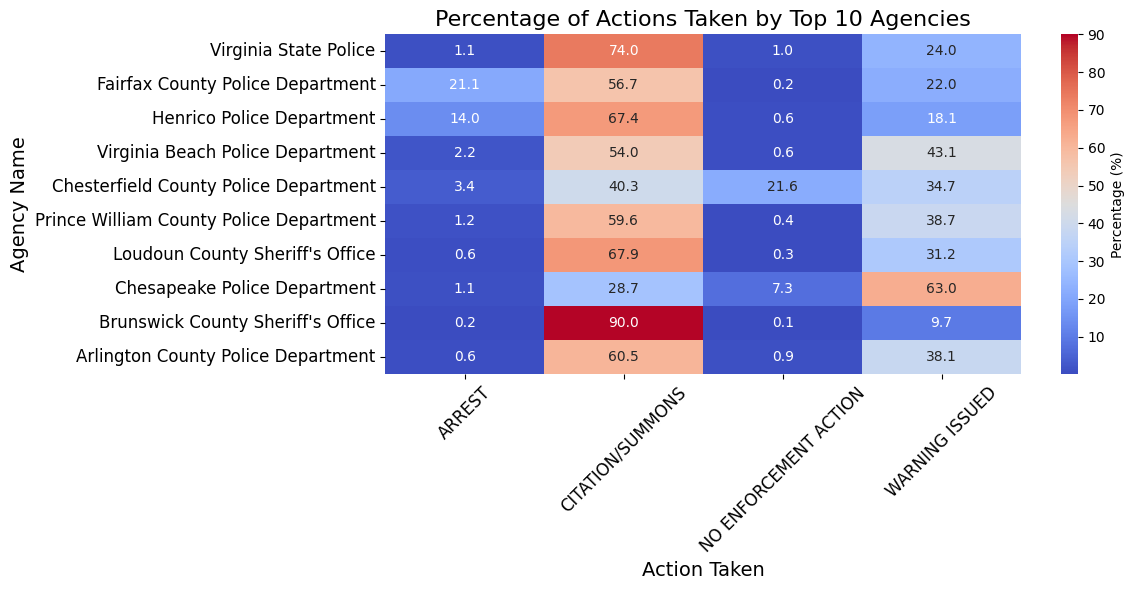

In [92]:
# Get the top 10 agencies with the most actions
top_agencies = grouped_data.sum(axis=1).nlargest(10).index
top_proportions = proportions.loc[top_agencies]

# Plot a heatmap for the top agencies
plt.figure(figsize=(12, 6))
sns.heatmap(top_proportions, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Percentage (%)'})

# Adding titles and labels
plt.title('Percentage of Actions Taken by Top 10 Agencies', fontsize=16)
plt.xlabel('Action Taken', fontsize=14)
plt.ylabel('Agency Name', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

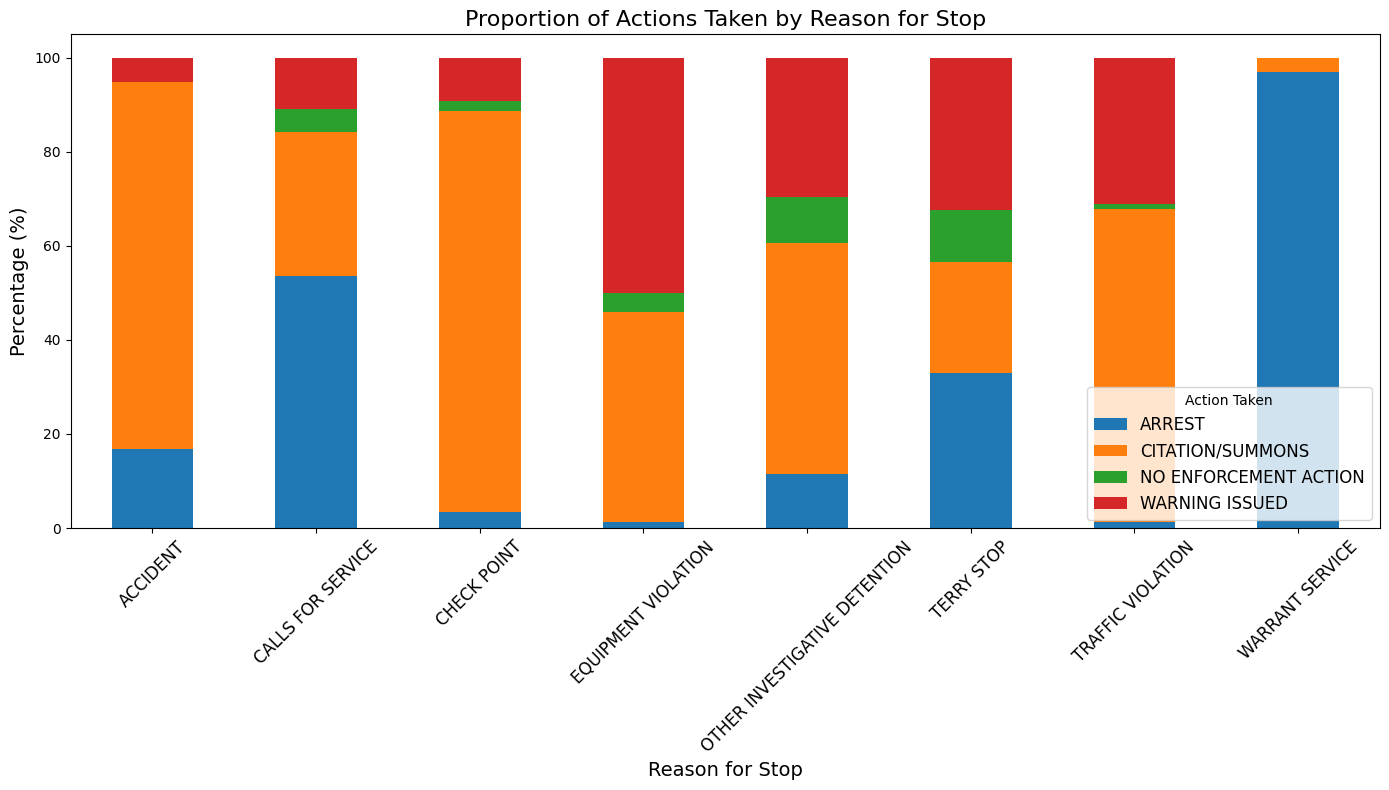

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame is already loaded as `df`
# Group the data by reason for stop and action taken
grouped_data = df.groupby(['REASON FOR STOP', 'ACTION TAKEN']).size().unstack(fill_value=0)

# Calculate proportions
proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plot a stacked bar chart
proportions.plot(kind='bar', stacked=True, figsize=(14, 8))

# Adding titles and labels
plt.title('Proportion of Actions Taken by Reason for Stop', fontsize=16)
plt.xlabel('Reason for Stop', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='Action Taken', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

### not really important

In [73]:
from collections import defaultdict

for i in range(4):
    print("CLASSIFIER FOR", i)
    feature_importances = log_reg.coef_[i]

    nom_cat_encoder = full_pipeline.named_transformers_["nom_cat"]
    nom_cat_one_hot_attribs = []
    for i, categories in enumerate(nom_cat_encoder.categories_):
        nom_cat_one_hot_attribs += [f"{nominal_cat_attrs[i]}_{category}" for category in categories]

    ord_cat_encoder = full_pipeline.named_transformers_["ord_cat"]
    ord_cat_attribs = ordinal_cat_attrs

    attrs = num_attrs + nom_cat_one_hot_attribs + ord_cat_attribs

    # Double check lengths match, otherwise there is not a correct mapping
    print(len(feature_importances), len(attrs))

    aggregated_nominal_cat = defaultdict(float)

    sorted_feature_importances = sorted(zip(feature_importances, attrs), reverse=True)
    sorted_aggregates = []
    for importance, name in sorted_feature_importances:
        if name.split("_")[0] in nominal_cat_attrs:
            aggregated_nominal_cat[name.split("_")[0]] += importance
        else:
            sorted_aggregates.append((importance, name))

    for name in aggregated_nominal_cat:
        sorted_aggregates.append((aggregated_nominal_cat[name], name))

    sorted_aggregates.sort(reverse=True)
    for importance, name in sorted_aggregates:
        print(f"{name}: {importance:.4f}")

CLASSIFIER FOR 0
55262 55262
PERSON SEARCHED: 0.1742
VIOLATION TYPE: 0.1742
GENDER: 0.1742
FORCE USED BY OFFICER: 0.1742
ADDITIONAL ARREST: 0.1742
RACE: 0.1742
ETHNICITY: 0.1742
JURISDICTION: 0.1742
LOCATION: 0.1742
FORCE USED BY SUBJECT: 0.1742
VEHICLE SEARCHED: 0.1742
SPECIFIC VIOLATION: 0.1742
ENGLISH SPEAKING: 0.1742
PERSON TYPE: 0.1742
REASON FOR STOP: 0.1742
RESIDENCY: 0.1742
AGENCY NAME: 0.1742
AGE: 0.0279
STOP_DATE: -0.0017
CLASSIFIER FOR 1
55262 55262
REASON FOR STOP: 0.0665
VEHICLE SEARCHED: 0.0665
PERSON SEARCHED: 0.0665
FORCE USED BY OFFICER: 0.0665
ETHNICITY: 0.0665
SPECIFIC VIOLATION: 0.0665
ADDITIONAL ARREST: 0.0665
PERSON TYPE: 0.0665
GENDER: 0.0665
RACE: 0.0665
JURISDICTION: 0.0665
RESIDENCY: 0.0665
FORCE USED BY SUBJECT: 0.0665
AGENCY NAME: 0.0665
LOCATION: 0.0665
VIOLATION TYPE: 0.0665
ENGLISH SPEAKING: 0.0665
AGE: 0.0385
STOP_DATE: 0.0008
CLASSIFIER FOR 2
55262 55262
STOP_DATE: 0.0002
AGE: -0.0691
REASON FOR STOP: -0.1505
VEHICLE SEARCHED: -0.1505
PERSON TYPE: -0.15

## START JACOB'S LINEAR REGRESSION

In [ ]:
# label_encoder = LabelEncoder()
# df['ACTION TAKEN'] = label_encoder.fit_transform(df['ACTION TAKEN'])

# X = df.drop(columns=['ACTION TAKEN'])
# y = df['ACTION TAKEN']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# categorical_cols = X.select_dtypes(include=['object']).columns
# numerical_cols = X.select_dtypes(exclude=['object']).columns

# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ]
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression(max_iter=500))
# ])

In [ ]:
# param_grid = {
#     'classifier__C': [0.01, 0.1, 1, 10, 100]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Output the best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# # Make predictions using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Convert predictions and y_test back to original categorical labels
# y_pred_labels = label_encoder.inverse_transform(y_pred)
# y_test_labels = label_encoder.inverse_transform(y_test)

# # Evaluate and display results
# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# print(f"Test Accuracy: {accuracy}")
# print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Best Parameters: {'classifier__C': 1}
Best Cross-Validation Accuracy: 0.7827625000000001
Test Accuracy: 0.7861

Classification Report:
                        precision    recall  f1-score   support

               ARREST       0.94      0.85      0.89       884
     CITATION/SUMMONS       0.80      0.93      0.86     14071
NO ENFORCEMENT ACTION       0.54      0.26      0.35       152
       WARNING ISSUED       0.65      0.37      0.47      4893

             accuracy                           0.79     20000
            macro avg       0.73      0.60      0.65     20000
         weighted avg       0.77      0.79      0.76     20000



## START HENRY'S SVM

In [ ]:
# categorical_columns = df.select_dtypes(include=['object']).columns
# df[categorical_columns] = df[categorical_columns].astype(str)

# # Convert the target column to numeric labels
# label_encoder = LabelEncoder()
# df['ACTION TAKEN'] = label_encoder.fit_transform(df['ACTION TAKEN'])

# # Separate features and target
# X = df.drop(columns=['ACTION TAKEN'])  # Replace 'ACTION TAKEN' with your actual target column name
# y = df['ACTION TAKEN']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=27
# )

# # Identify categorical and numerical columns
# categorical_cols = X.select_dtypes(include=['object']).columns
# numerical_cols = X.select_dtypes(exclude=['object']).columns

# # Define preprocessing for numeric and categorical data
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# # Convert all categorical columns to string before processing
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Combine preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ]
# )

# # Preprocess the training and testing data
# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)

# # Verify dataset sizes
# print(f"Total rows in dataset: {len(df)}")  # Should be 100,000
# print(f"Training set size: {len(X_train), len(y_train)}")
# print(f"Test set size: {len(X_test), len(y_test)}")

Total rows in dataset: 100000
Training set size: (80000, 80000)
Test set size: (20000, 20000)


In [ ]:
# X_train_prepared.shape

(80000, 45978)

In [ ]:
# X_test_prepared.shape

(20000, 45978)

In [ ]:
# # Define a parameter grid
# param_grid = {
#     'C': [1],  # Experiment with a range of C values
#     'gamma': ['auto'],
# }

# # Create an SVM model
# svm_clf = SVC(kernel='rbf', decision_function_shape='ovr', random_state=27)

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(svm_clf, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train_prepared, y_train)

# # Get the best model from the grid search
# best_svm_clf = grid_search.best_estimator_
# print(best_svm_clf)

# # Predict on the test data
# y_pred = best_svm_clf.predict(X_test_prepared)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................................C=1, gamma=auto; total time= 4.3min
[CV] END ....................................C=1, gamma=auto; total time= 4.3min
[CV] END ....................................C=1, gamma=auto; total time= 4.3min
[CV] END ....................................C=1, gamma=auto; total time= 4.3min
[CV] END ....................................C=1, gamma=auto; total time= 4.3min
SVC(C=1, gamma='auto', random_state=27)


In [ ]:
# y_pred = best_svm_clf.predict(X_test_prepared)

In [ ]:
# print(best_svm_clf.best_params_)
# print(type(y_pred), len(y_pred), y_pred)
# print(type(y_test), len(y_test), y_test)

# # Convert predictions and y_test back to original categorical labels
# y_pred_labels = label_encoder.inverse_transform(y_pred)
# y_test_labels = label_encoder.inverse_transform(y_test)

# report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Best Parameters:", grid_search.best_params_)
# print("Accuracy:", accuracy)
# print("\nClassification Report:\n", report)

AttributeError: 'SVC' object has no attribute 'best_params_'